In [12]:
## Imports
import torch
import torchvision ## Contains some utilities for working with the image data
from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt
#%matplotlib inline
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import nn
import time
from datetime import datetime
from IPython.display import clear_output
from datetime import timedelta
# import tuple
from typing import Any, Tuple
from PIL import Image
import pickle

In [13]:
data_dir = '../../../../data/kaggle/'

In [14]:


# Define Dataset class
class FashionistaDataset(FashionMNIST):
    def __init__(self, root='./', labels=None, transform=None, train=True, data=None, download=False, targets=''):
        super().__init__(root, transform=transform, download=download, train=train)
        if data is not None:
            self.data = data
        if targets is not '':
            self.targets = targets
        # self.labels = torch.tensor(labels, dtype=torch.long) if labels is not None else None
        # self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        # print(self.data[index].shape)
        # Fetch the image
        if type(self.data[index]) == torch.Tensor:
            img = self.data[index].reshape(28, 28).numpy().astype('uint8')
        else:
            img = self.data[index].reshape(28, 28).astype('uint8')
        # print("type of img: ", type(img))
        # print(img.shape)

        # Convert to PIL Image for consistency
        img = Image.fromarray(img, mode="L")
        # img = Image.fromarray(img.numpy(), mode="L")

        # Apply transformations to the image
        if self.transform is not None:
            img = self.transform(img)

        # print(self.targets)
        # If targets exist, process and return them; otherwise, return only the image
        if self.targets is not None:
            target = int(self.targets[index])  # Convert target to int
            if self.target_transform is not None:
                target = self.target_transform(target)
            return img, target
        else:
            return img  # No label for test data

<>:7: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:7: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/var/folders/s8/kl6fzfms2b7gvbxjt5t2wmr80000gn/T/ipykernel_6254/4054308081.py:7: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if targets is not '':


In [15]:
dataset = FashionistaDataset(root = data_dir, download = True)
print(len(dataset))

60000


Label: 9


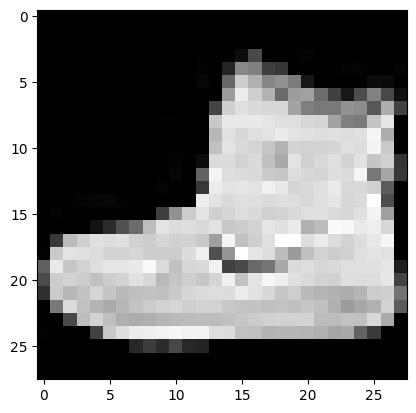

In [16]:
image, label = dataset[0]
plt.imshow(image, cmap = 'gray')
print('Label:', label)

In [17]:
# ## MNIST dataset(images and labels)
# mnist_dataset = FashionMNIST(root = data_dir, train = True, transform = transforms.ToTensor())
# print(mnist_dataset)

RuntimeError: Dataset not found. You can use download=True to download it

In [9]:
image_tensor, label = mnist_dataset[0]
print(image_tensor.shape, label)

torch.Size([1, 28, 28]) 9


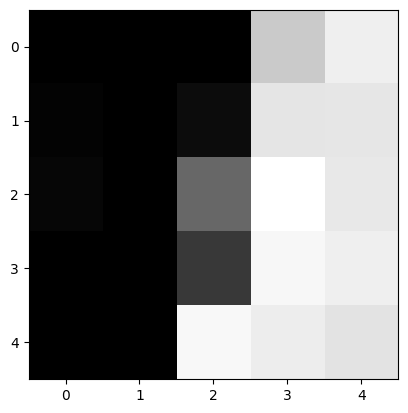

In [10]:
## Plot the image of the tensor
plt.imshow(image_tensor[0,10:15,10:15],cmap = 'gray')

## training and validation

In [11]:
train_data, validation_data = random_split(mnist_dataset, [50000, 10000])
## Print the length of train and validation datasets
print("length of Train Datasets: ", len(train_data))
print("length of Validation Datasets: ", len(validation_data))

length of Train Datasets:  50000
length of Validation Datasets:  10000


In [15]:
# Define data augmentation and transforms
train_transform = transforms.Compose([
    transforms.RandomRotation(12),
    transforms.RandomAffine(0, translate=(0.15, 0.15), shear=15, scale=(0.85, 1.15)),
    transforms.ToTensor()
])

val_transform = transforms.ToTensor()

In [16]:
fashion_data = FashionistaDataset(root = data_dir, train = True, transform = train_transform)
print(fashion_data)
print(len(fashion_data))
fashion_data[0][0].shape


Dataset FashionistaDataset
    Number of datapoints: 60000
    Root location: ../../../../data/kaggle/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-12.0, 12.0], interpolation=nearest, expand=False, fill=0)
               RandomAffine(degrees=[0.0, 0.0], translate=(0.15, 0.15), scale=(0.85, 1.15), shear=[-15.0, 15.0])
               ToTensor()
           )
60000


torch.Size([1, 28, 28])

In [11]:
data_indices = list(range(len(fashion_data)))
labels = [fashion_data[i][1] for i in data_indices]  # Assuming fashion_data[i] returns (image, label)

# Perform train-test split
train_indices, val_indices = train_test_split(
    data_indices, 
    test_size=10000 / len(fashion_data),  # Equivalent to 10k validation samples from 60k
    random_state=42,  # For reproducibility
    stratify=labels  # Ensures balanced class distribution
)

# Create Subsets for train and validation datasets
train_data = Subset(fashion_data, train_indices)
validation_data = Subset(fashion_data, val_indices)
len(train_data), len(validation_data)

NameError: name 'fashion_data' is not defined

In [22]:
batch_size = 128
train_loader = DataLoader(train_data, batch_size, shuffle = True)
val_loader = DataLoader(validation_data, batch_size, shuffle = False)

In [81]:
class FashionistaModel(nn.Module):
    def __init__(self):
        super().__init__()
        # CNN architecture
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, padding=2),  # Input: 1x28x28, Output: 64x28x28
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),  # Output: 64x28x28
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),  # Output: 64x14x14
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Output: 128x14x14
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),  # Output: 128x14x14
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),  # Output: 128x7x7
            nn.Dropout(0.3),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # Output: 256x7x7
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),  # Output: 256x3x3
            nn.Dropout(0.4),
        )

        self.fc = nn.Sequential(
            nn.Flatten(),  # Flatten the tensor for dense layers
            nn.Linear(256 * 3 * 3, 512),  # Fully connected layer
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 10)  # Output layer for 10 classes
        )
    
    def forward(self, xb):
        # Pass through CNN layers
        xb = self.cnn(xb)
        # Pass through fully connected layers
        out = self.fc(xb)
        return out

    def training_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate the loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss, 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

model = FashionistaModel()
for k in model.state_dict().keys():
    print(k, "\t", model.state_dict()[k].shape)

cnn.0.weight 	 torch.Size([64, 1, 5, 5])
cnn.0.bias 	 torch.Size([64])
cnn.1.weight 	 torch.Size([64])
cnn.1.bias 	 torch.Size([64])
cnn.1.running_mean 	 torch.Size([64])
cnn.1.running_var 	 torch.Size([64])
cnn.1.num_batches_tracked 	 torch.Size([])
cnn.3.weight 	 torch.Size([64, 64, 5, 5])
cnn.3.bias 	 torch.Size([64])
cnn.4.weight 	 torch.Size([64])
cnn.4.bias 	 torch.Size([64])
cnn.4.running_mean 	 torch.Size([64])
cnn.4.running_var 	 torch.Size([64])
cnn.4.num_batches_tracked 	 torch.Size([])
cnn.8.weight 	 torch.Size([128, 64, 3, 3])
cnn.8.bias 	 torch.Size([128])
cnn.9.weight 	 torch.Size([128])
cnn.9.bias 	 torch.Size([128])
cnn.9.running_mean 	 torch.Size([128])
cnn.9.running_var 	 torch.Size([128])
cnn.9.num_batches_tracked 	 torch.Size([])
cnn.11.weight 	 torch.Size([128, 128, 3, 3])
cnn.11.bias 	 torch.Size([128])
cnn.12.weight 	 torch.Size([128])
cnn.12.bias 	 torch.Size([128])
cnn.12.running_mean 	 torch.Size([128])
cnn.12.running_var 	 torch.Size([128])
cnn.12.num_batche

In [24]:
for images, labels in train_loader:
    outputs = model(images)
    break
    
print('outputs shape: ', outputs.shape)
print('Sample outputs: \n', outputs[:2].data)

outputs shape:  torch.Size([128, 10])
Sample outputs: 
 tensor([[ 0.0730, -0.1182, -0.2732, -0.3171,  0.0085,  0.2078, -0.3174, -0.4448,
         -0.0835,  0.1948],
        [ 0.4744, -0.2640, -0.3180,  0.3144, -0.9573, -0.2797,  0.5095, -0.0596,
          0.4760, -0.1029]])


In [26]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return(torch.tensor(torch.sum(preds == labels).item()/ len(preds)))

print("Accuracy: ",accuracy(outputs, labels))
print("\n")
loss_fn = F.cross_entropy
print("Loss Function: ",loss_fn)
print("\n")
## Loss for the current batch
loss = loss_fn(outputs, labels)
print(loss)

Accuracy:  tensor(0.0625)


Loss Function:  <function cross_entropy at 0x12c59b560>


tensor(2.4832, grad_fn=<NllLossBackward0>)


In [28]:
def evaluate(model, val_loader):
  outputs = [model.validation_step(batch) for batch in val_loader]
  return(model.validation_epoch_end(outputs))

def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(), lr)
  for epoch in range(epochs):
      
    ## Training Phas
    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    
    ## Validation phase
    result = evaluate(model, val_loader)
    model.epoch_end(epoch, result)
    history.append(result)
  return(history)

In [29]:
result0 = evaluate(model, val_loader)
result0

{'val_loss': 2.403740882873535, 'val_acc': 0.10215585678815842}

In [82]:
# training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FashionistaModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3)

In [83]:
# Training loop
epochs = 50
best_val_loss = float('inf')
early_stop_counter = 0
patience = 5
losses = []
val_losses = []
val_accuracies = []
print("Training on", device)
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

    val_loss /= len(val_loader)
    train_loss /= len(train_loader)
    val_accuracy = correct / total

    losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "fashion-mnist-cnn.pth")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

# Load the best model for inference
model.load_state_dict(torch.load("fashion-mnist-cnn.pth"))
model.eval()

Training on cpu
Epoch 1/50


KeyboardInterrupt: 

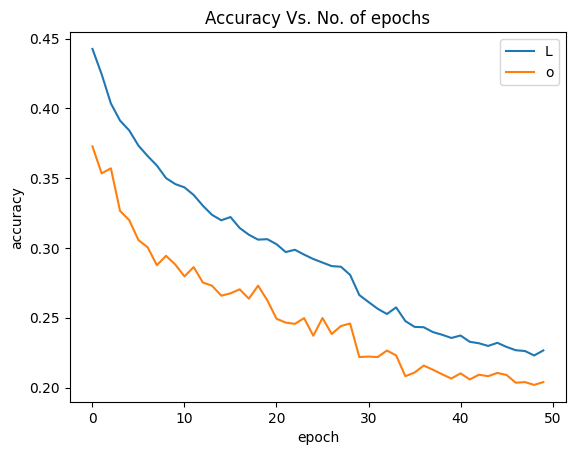

In [36]:
# plot the training and validation losses
plt.plot(losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend("Loss")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy Vs. No. of epochs')
plt.show()

In [27]:
def get_model_accuracy(model, data_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
    return correct / total

# current model validation accuracy
model.eval()
val_loss = 0
correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        val_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

val_loss /= len(val_loader)
train_loss /= len(train_loader)
val_accuracy = correct / total
val_accuracy, val_loss

(0.9033, 0.7152208015322685)

In [42]:
bestest_val_loss = val_loss

In [43]:
# Training loop
epochs = 50
best_val_loss = bestest_val_loss
early_stop_counter = 0
patience = 5
losses = []
val_losses = []
val_accuracies = []
print("Training on", device)
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

    val_loss /= len(val_loader)
    train_loss /= len(train_loader)
    val_accuracy = correct / total

    losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "fashion-mnist-cnn.pth")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

# Load the best model for inference
model.load_state_dict(torch.load("fashion-mnist-cnn.pth"))
model.eval()

Training on cpu
Epoch 1/50
Epoch 1/50, Train Loss: 0.2284, Val Loss: 0.2048, Val Accuracy: 0.9275
Epoch 2/50
Epoch 2/50, Train Loss: 0.2246, Val Loss: 0.2055, Val Accuracy: 0.9275
Epoch 3/50
Epoch 3/50, Train Loss: 0.2245, Val Loss: 0.2016, Val Accuracy: 0.9283
Epoch 4/50
Epoch 4/50, Train Loss: 0.2217, Val Loss: 0.2018, Val Accuracy: 0.9273
Epoch 5/50
Epoch 5/50, Train Loss: 0.2223, Val Loss: 0.2013, Val Accuracy: 0.9287
Epoch 6/50
Epoch 6/50, Train Loss: 0.2211, Val Loss: 0.2034, Val Accuracy: 0.9253
Epoch 7/50
Epoch 7/50, Train Loss: 0.2223, Val Loss: 0.2002, Val Accuracy: 0.9285
Epoch 8/50
Epoch 8/50, Train Loss: 0.2220, Val Loss: 0.2039, Val Accuracy: 0.9283
Epoch 9/50
Epoch 9/50, Train Loss: 0.2232, Val Loss: 0.2013, Val Accuracy: 0.9300
Epoch 10/50
Epoch 10/50, Train Loss: 0.2214, Val Loss: 0.2006, Val Accuracy: 0.9277
Epoch 11/50
Epoch 11/50, Train Loss: 0.2199, Val Loss: 0.2019, Val Accuracy: 0.9268
Epoch 12/50
Epoch 12/50, Train Loss: 0.2227, Val Loss: 0.2002, Val Accuracy: 0

/var/folders/s8/kl6fzfms2b7gvbxjt5t2wmr80000gn/T/ipykernel_21157/2909279292.py:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("fashion-mn

FashionistaModel(
  (cnn): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.3, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.01)
    (14): MaxP

In [45]:
accuracy = get_model_accuracy(model, val_loader)
accuracy

0.9287

## new model

In [18]:
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)  # Global Average Pooling
        self.fc1 = nn.Linear(in_channels, in_channels // reduction, bias=False)  # Squeeze
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(in_channels // reduction, in_channels, bias=False)  # Excitation
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch, channels, _, _ = x.size()
        # Squeeze: Global Average Pooling
        se = self.global_avg_pool(x).view(batch, channels)
        # Excitation: Two fully connected layers with reduction
        se = self.fc1(se)
        se = self.relu(se)
        se = self.fc2(se)
        se = self.sigmoid(se).view(batch, channels, 1, 1)
        # Scale: Multiply input by recalibrated weights
        return x * se

In [ ]:
class CBAMBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(CBAMBlock, self).__init__()
        self.se = SEBlock(in_channels, reduction)
        self.spatial_gate = nn.Sequential(
            nn.Conv2d(in_channels, 1, kernel_size=7, padding=3),
            nn.Sigmoid()
        )

    def forward(self, x):
        x_se = self.se(x)
        x_spatial = x_se * self.spatial_gate(x_se)
        return x_spatial

In [40]:
class FashionistaModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        # CNN architecture with SE blocks
        self.cnn = nn.Sequential(
            # Block 1
            nn.Conv2d(1, 64, kernel_size=3, padding=1),  # Input: 1x28x28, Output: 64x28x28
            # nn.Conv2d(64, 64, kernel_size=5, padding=2),  # Input: 1x28x28, Output: 64x28x28
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # Output: 64x28x28
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            # SEBlock(64),  # Add SE block here
            nn.MaxPool2d(2),  # Output: 64x14x14
            nn.Dropout(0.32),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Output: 128x14x14
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),  # Output: 128x14x14
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            SEBlock(128),  # Add SE block here
            nn.MaxPool2d(2),  # Output: 128x7x7
            nn.Dropout(0.38),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # Output: 256x7x7
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),  # Output: 256x7x7
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            SEBlock(256),  # Add SE block here
            nn.MaxPool2d(2),  # Output: 256x3x3
            nn.Dropout(0.35),
        )

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Flatten(),  # Flatten the tensor for dense layers
            nn.Linear(256 * 3 * 3, 512),  # Fully connected layer
            nn.LeakyReLU(),
            nn.Dropout(0.35),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 10)  # Output layer for 10 classes
        )
    
    def forward(self, xb):
        # Pass through CNN layers
        xb = self.cnn(xb)
        # Pass through fully connected layers
        out = self.fc(xb)
        return out

    def training_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate the loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss, 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

model = FashionistaModel()
for k in model.state_dict().keys():
    print(k, "\t", model.state_dict()[k].shape)

cnn.0.weight 	 torch.Size([64, 1, 3, 3])
cnn.0.bias 	 torch.Size([64])
cnn.1.weight 	 torch.Size([64])
cnn.1.bias 	 torch.Size([64])
cnn.1.running_mean 	 torch.Size([64])
cnn.1.running_var 	 torch.Size([64])
cnn.1.num_batches_tracked 	 torch.Size([])
cnn.3.weight 	 torch.Size([64, 64, 3, 3])
cnn.3.bias 	 torch.Size([64])
cnn.4.weight 	 torch.Size([64])
cnn.4.bias 	 torch.Size([64])
cnn.4.running_mean 	 torch.Size([64])
cnn.4.running_var 	 torch.Size([64])
cnn.4.num_batches_tracked 	 torch.Size([])
cnn.8.weight 	 torch.Size([128, 64, 3, 3])
cnn.8.bias 	 torch.Size([128])
cnn.9.weight 	 torch.Size([128])
cnn.9.bias 	 torch.Size([128])
cnn.9.running_mean 	 torch.Size([128])
cnn.9.running_var 	 torch.Size([128])
cnn.9.num_batches_tracked 	 torch.Size([])
cnn.11.weight 	 torch.Size([128, 128, 3, 3])
cnn.11.bias 	 torch.Size([128])
cnn.12.weight 	 torch.Size([128])
cnn.12.bias 	 torch.Size([128])
cnn.12.running_mean 	 torch.Size([128])
cnn.12.running_var 	 torch.Size([128])
cnn.12.num_batche

In [41]:
# Define data augmentation and transforms
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(12),
    transforms.RandomAffine(0, translate=(0.15, 0.15), shear=15, scale=(0.85, 1.15)),
    transforms.RandomResizedCrop(28, scale=(0.85, 1.0), ratio=(0.9, 1.05)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

fashion_data = FashionistaDataset(root = data_dir, train = True, transform = train_transform)
fashion_val_data = FashionistaDataset(root = data_dir, train = False, transform = val_transform)
print(fashion_data)
print(len(fashion_data))
fashion_data[0][0].shape


Dataset FashionistaDataset
    Number of datapoints: 60000
    Root location: ../../../../data/kaggle/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-12.0, 12.0], interpolation=nearest, expand=False, fill=0)
               RandomAffine(degrees=[0.0, 0.0], translate=(0.15, 0.15), scale=(0.85, 1.15), shear=[-15.0, 15.0])
               RandomResizedCrop(size=(28, 28), scale=(0.85, 1.0), ratio=(0.9, 1.05), interpolation=bilinear, antialias=True)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
60000


torch.Size([1, 28, 28])

In [42]:
data_indices = list(range(len(fashion_data)))
labels = [fashion_data[i][1] for i in data_indices]  # Assuming fashion_data[i] returns (image, label)

# Perform train-test split
train_indices, val_indices = train_test_split(
    data_indices, 
    test_size=10000 / len(fashion_data),  # Equivalent to 10k validation samples from 60k
    random_state=9,  # For reproducibility
    stratify=labels  # Ensures balanced class distribution
)

# Create Subsets for train and validation datasets
train_data = Subset(fashion_data, train_indices)
validation_data = Subset(fashion_data, val_indices)
len(train_data), len(validation_data)

(50000, 10000)

In [43]:
batch_size = 256
train_loader = DataLoader(train_data, batch_size, shuffle = True)
val_loader = DataLoader(validation_data, batch_size, shuffle = False)

In [44]:
# training setup
num_epochs = 100
best_val_loss = float('inf')
early_stop_counter = 0
patience = 5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FashionistaModel().to(device)
class_weights = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.5, 1.0, 1.0, 1.0]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=0.003, weight_decay=1e-3, eps=1e-8)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0005, max_lr=0.005, step_size_up=5, cycle_momentum=False)

losses = []
val_losses = []
val_accuracies = []
lrates = []

In [45]:
len(lrates), len(losses), len(val_losses), len(val_accuracies)

(0, 0, 0, 0)

In [55]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
# optimizer = optim.AdamW(model.parameters(), lr=0.003, weight_decay=1e-3, eps=1e-8)
# scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0005, max_lr=0.005, step_size_up=5, cycle_momentum=False)
optimizer = optim.Adam(model.parameters(), lr=1e-9,  weight_decay=1e-3)
# scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
# scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=patience)
# scheduler for late cnn plateau
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3)
early_stop_counter = 0

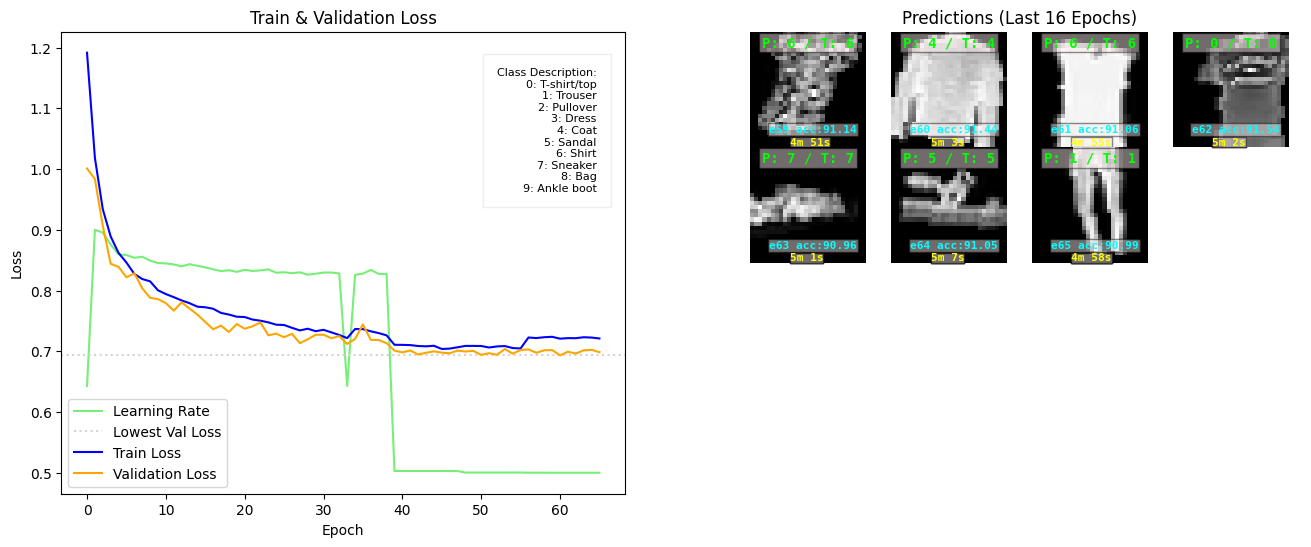

Epoch 7/100, Train Loss: 0.7211, Val Loss: 0.6986, Val Accuracy: 90.9900, Duration: 4m 58s, End Time: 15:27:36
Early stopping counter: 4
Best Validation Loss: 0.6933
Best Validation Accuracy: 91.5400
Average time per epoch: 5m 1s
Next epoch ETA: 15:32:38
Early stopping triggered.
Training completed in 00:35:07.


/var/folders/s8/kl6fzfms2b7gvbxjt5t2wmr80000gn/T/ipykernel_6254/2911932890.py:161: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_

Validation Accuracy: 0.9105


In [56]:
# Ensure correct backend for Jupyter Notebook
%matplotlib inline

# Initialize graph for loss and accuracy
recent_predictions = []
times_per_epoch = []
model_version = 'v4'
print("Training on", device)
checkpoint_name = f"fashion-mnist-cnn-{model_version}.pth"

start_time = time.time()  # Start training timer

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    print(f"Epoch {epoch+1}/{num_epochs}: with learning rate {optimizer.param_groups[0]['lr']:.6f}. Working on {device}...")
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

    val_loss /= len(val_loader)
    train_loss /= len(train_loader)
    val_accuracy = correct / 100

    losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    lrates.append(optimizer.param_groups[0]['lr'])

    # Calculate epoch duration
    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    # epoch duration to mintes and seconds
    epoch_mins = int(epoch_duration / 60)
    epoch_secs = int(epoch_duration - (epoch_mins * 60))
    timestamp = datetime.now().strftime("%H:%M:%S")

    times_per_epoch.append(epoch_duration)

    # Update Loss Graph (Left)

    # Clear the figure
    clear_output(wait=True)

    # Create a new figure and subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    loss_ax, pred_ax = axes

    # Update Loss Graph (Left)
    normalized_lrates = [lr / max(lrates) for lr in lrates]
    # range from 0.4 to 0.6
    normalized_lrates = [0.5 + (0.4 * lr) for lr in normalized_lrates]
    loss_ax.plot(normalized_lrates, label='Learning Rate', color='#7e7')
    # plot dotted lightgray line at lowest val_loss
    loss_ax.axhline(y=min(val_losses), color='lightgray', linestyle='dotted', label='Lowest Val Loss')
    loss_ax.plot(losses, label='Train Loss', color='blue')
    loss_ax.plot(val_losses, label='Validation Loss', color='orange')
    loss_ax.legend()
    loss_ax.set_xlabel('Epoch')
    loss_ax.set_ylabel('Loss')
    loss_ax.set_title('Train & Validation Loss')
    # print class description on topright, below the legend
    loss_ax.text(0.95, 0.65, 'Class Description:\n0: T-shirt/top\n1: Trouser\n2: Pullover\n3: Dress\n4: Coat\n5: Sandal\n6: Shirt\n7: Sneaker\n8: Bag\n9: Ankle boot', verticalalignment='bottom', horizontalalignment='right', transform=loss_ax.transAxes, color='black', fontsize=8, bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10, 'edgecolor': '#dedede'})

    sample_images, sample_labels = next(iter(val_loader))
    for i in range(epoch):
        sample_images, sample_labels = next(iter(val_loader))
    sample_images, sample_labels = sample_images.to(device), sample_labels.to(device)
    with torch.no_grad():
        sample_outputs = model(sample_images)
        _, sample_preds = torch.max(sample_outputs, 1)

    recent_index = epoch+1
    recent_predictions.append((sample_images[:recent_index].cpu(), sample_preds[:recent_index].cpu(), sample_labels[:recent_index].cpu()))
    if len(recent_predictions) > 16:
        recent_predictions.pop(0)

    # Update Prediction Grid (Right)
    pred_ax.set_title("Predictions (Last 16 Epochs)")
    pred_ax.axis('off')
    rows, cols = 4, 4
    for idx, (images, preds, labels) in enumerate(recent_predictions[:16]):
        for img, pred, label in zip(images, preds, labels):
            img = img.squeeze(0)  # Remove channel dimension
            ax = pred_ax.inset_axes([idx % cols / cols, 1 - (idx // cols + 1) / rows, 1 / cols, 1 / rows])
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            ax.set_title(f"P: {pred} / T: {label}", fontsize=10, color='#0f0' if pred == label else 'red', fontweight='bold', fontfamily='monospace', y=0.8, bbox={'facecolor': '#fee', 'alpha': 0.45, 'pad': 2})
            current_epoch_idx = - len(recent_predictions) + idx
            epoch_val_accuracy = val_accuracies[current_epoch_idx]
            epoch_id = len(val_accuracies) + current_epoch_idx
            ax.text(4, 24, f"e{epoch_id} acc:{epoch_val_accuracy:.2f}", fontsize=8, color='cyan', fontfamily='monospace', fontweight='bold', bbox={'facecolor': '#fee', 'alpha': 0.45, 'pad': 1})
            # shadow for the text

            epoch_mins = int(times_per_epoch[current_epoch_idx] / 60)
            epoch_secs = int(times_per_epoch[current_epoch_idx] - (epoch_mins * 60))
            epoch_time_str = f"{epoch_mins}m {epoch_secs}s"
            ax.text(9, 27, f"{epoch_time_str}", fontsize=8, color='yellow', fontfamily='monospace', fontweight='bold', bbox={'facecolor': '#fee', 'alpha': 0.45, 'pad': 0})

    # Display the updated plot
    plt.show()

    # save the plot
    fig.savefig(f"epoch_{len(val_accuracies)}_plot-cnn-{model_version}.png")

    print(
        f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, "
        f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, "
        f"Duration: {epoch_mins}m {epoch_secs}s, End Time: {timestamp}"
    )

    total_time = time.time() - start_time
    print(f"Early stopping counter: {early_stop_counter}")
    print(f"Best Validation Loss: {best_val_loss:.4f}")
    print(f"Best Validation Accuracy: {max(val_accuracies):.4f}")
    avg_time = total_time / len(times_per_epoch)
    avg_mins = int(avg_time / 60)
    avg_secs = int(avg_time - (avg_mins * 60))
    print(f"Average time per epoch: {avg_mins}m {avg_secs}s")
    print(f"Next epoch ETA: {(datetime.now() + timedelta(seconds=avg_time)).strftime('%H:%M:%S')}")

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), checkpoint_name)
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

total_time = time.time() - start_time
total_time_formatted = time.strftime("%H:%M:%S", time.gmtime(total_time))
print(f"Training completed in {total_time_formatted}.")


# Load the best model for inference
model.load_state_dict(torch.load(checkpoint_name))
model.eval()

accuracy = get_model_accuracy(model, val_loader)

print(f"Validation Accuracy: {accuracy:.4f}")

In [49]:
# acurracy before reconfiguring droputs and learning rate schedulers
accuracy = get_model_accuracy(model, val_loader)

print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.8983


In [57]:
# acurracy after reconfiguring droputs and learning rate schedulers and without most transformations (using val_transofrms)
accuracy = get_model_accuracy(model, val_loader)

print(f"Validation Accuracy: {accuracy:.4f}")


Validation Accuracy: 0.9110


In [52]:
# load the model and its training history
with open(f'fashion-mnist-cnn-v4-training-data.pickle', 'rb') as f:
# with open(f'fashion-mnist-cnn-{model_version}-training-data.pickle', 'rb') as f:
    training_data = pickle.load(f)
    val_accuracies = training_data['validation_accuracy']
    val_losses = training_data['validation_loss']
    losses = training_data['training_loss']
    lrates = training_data['learning_rates']
    times_per_epoch = training_data['times_per_epoch']
    total_time = training_data['total_time']
    best_val_loss = training_data['best_val_loss']
    model_version = training_data['model_version']
    model.load_state_dict(training_data['model_state'])
    optimizer.load_state_dict(training_data['optimizer_state'])
    # scheduler.load_state_dict(training_data['scheduler_state'])
    

## save current progress

In [59]:
# Save the model and its training history
training_data = {
    'model_state': model.state_dict(),
    'optimizer_state': optimizer.state_dict(),
    'scheduler_state': scheduler.state_dict(),
    'training_loss': losses,
    'validation_loss': val_losses,
    'validation_accuracy': val_accuracies,
    'learning_rates': lrates,
    'times_per_epoch': times_per_epoch,
    'total_time': total_time,
    'best_val_loss': best_val_loss,
    'best_val_accuracy': max(val_accuracies),
    'model_version': model_version
}

with open(f'fashion-mnist-cnn-{model_version}-training-data.pickle', 'wb') as f:
    pickle.dump(training_data, f)